<h2> Original data from Google Scholar, without asking Crossref</h2>

AGR. CAGR, and statistical tests

In [1]:
PRED_FILE = 'data/pred/metadata/pred_journals_count.xlsx'    
REG_FILE  = 'data/norm/metadata/good_journals_count.xlsx'   

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu

START_YEAR = 2020
END_YEAR   = 2024
YEARS      = list(range(START_YEAR, END_YEAR + 1))
RANGES     = [f"{y}→{y+1}" for y in YEARS[:-1]]
SHEET     = 'Sheet1'

journal_pairs = [
    ("International Journal of Applied Research in Social Sciences", "Discover Applied Sciences"),
    ("International Journal of Management & Entrepreneurship Research", "Journal of Business and Management Studies"),
    ("International Medical Science Research Journal", "Nature Machine Intelligence"),
    ("Finance & Accounting Research Journal", "Finance, Accounting and Business Analysis"),
    ("International Journal of Science and Research Archive", "SciPost Physics Core"),
]
pred_journals = list({pj for pj, _ in journal_pairs})
reg_journals  = list({rj for _, rj in journal_pairs})

def load_pivot(path):
    df = pd.read_excel(path, sheet_name=SHEET)
    df = df.rename(columns={'paper count':'paper_count'})
    df['year'] = df['year'].astype(int)
    df['paper_count'] = pd.to_numeric(df['paper_count'], errors='coerce')
    df = df[df['year'].between(START_YEAR, END_YEAR)]
    return df.groupby(['Journal','year'])['paper_count'].sum().unstack('year').fillna(0)

pred_piv = load_pivot(PRED_FILE)
reg_piv  = load_pivot(REG_FILE)

for piv in (pred_piv, reg_piv):
    for y, rng in zip(range(START_YEAR, END_YEAR), RANGES):
        mask = piv[y] > 0
        piv.loc[mask, rng] = (piv.loc[mask, y+1] - piv.loc[mask, y]) / piv.loc[mask, y] * 100
    piv.replace([np.inf, -np.inf], np.nan, inplace=True)

# ----  CAGR ----
# def compute_cagr(piv):
#     out = {}
#     for journal, row in piv.iterrows():
#         yrs = [y for y in YEARS if y in row.index]
#         if len(yrs)>=2 and row[yrs[0]]>0:
#             v1, v2 = row[yrs[0]], row[yrs[-1]]
#             out[journal] = ((v2/v1)**(1/(yrs[-1]-yrs[0])) - 1) * 100
#         else:
#             out[journal] = np.nan
#     return out

def compute_cagr_flexible(piv):
    out = {}
    for journal, row in piv.iterrows():
        non_zero_years = [y for y in YEARS if y in row.index and row[y] > 0]
        if len(non_zero_years) >= 2:
            start_year = non_zero_years[0]
            end_year = non_zero_years[-1]
            v1 = row[start_year]
            v2 = row[end_year]
            cagr = ((v2 / v1) ** (1 / (end_year - start_year)) - 1) * 100
            out[journal] = cagr
        else:
            out[journal] = np.nan
    return out


pred_cagr = compute_cagr_flexible(pred_piv)
reg_cagr  = compute_cagr_flexible(reg_piv)

pred_agr_vals = np.concatenate([
    pred_piv.loc[j, RANGES].dropna().values
    for j in pred_journals if j in pred_piv.index
])
reg_agr_vals  = np.concatenate([
    reg_piv.loc[j, RANGES].dropna().values
    for j in reg_journals if j in reg_piv.index
])

pred_agr_vals = pred_agr_vals[np.isfinite(pred_agr_vals)]
reg_agr_vals  = reg_agr_vals[np.isfinite(reg_agr_vals)]

pred_cagr_vals = np.array([pred_cagr[j] for j in pred_journals if not np.isnan(pred_cagr[j])])
reg_cagr_vals  = np.array([reg_cagr[j]  for j in reg_journals  if not np.isnan(reg_cagr[j])])

summary_agr = pd.DataFrame({
    'Group': ['Predatory','Regular'],
    'n': [len(pred_agr_vals), len(reg_agr_vals)],
    'Mean AGR (%)': [pred_agr_vals.mean(), reg_agr_vals.mean()],
    'Std AGR (%)': [pred_agr_vals.std(ddof=1), reg_agr_vals.std(ddof=1)]
})
summary_cagr = pd.DataFrame({
    'Group': ['Predatory','Regular'],
    'n': [len(pred_cagr_vals), len(reg_cagr_vals)],
    'Mean CAGR (%)': [pred_cagr_vals.mean(), reg_cagr_vals.mean()],
    'Std CAGR (%)': [pred_cagr_vals.std(ddof=1), reg_cagr_vals.std(ddof=1)]
})

print("\n=== Aggregated AGR Summary ===")
print(summary_agr.to_string(index=False))
print("\n=== Aggregated CAGR Summary ===")
print(summary_cagr.to_string(index=False))

def run_tests(x, y, label):
    # Welch's t-test
    t, p_t = ttest_ind(x, y, equal_var=False)
    # Cohen's d
    n1, n2 = len(x), len(y)
    s1, s2 = x.std(ddof=1), y.std(ddof=1)
    pooled = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1+n2-2))
    d = (x.mean() - y.mean()) / pooled
    # Mann-Whitney U
    u, p_u = mannwhitneyu(x, y, alternative='two-sided')
    r = 2*u/(n1*n2) - 1
    print(f"\n--- {label} Tests ---")
    print(f"Welch t-test: t = {t:.3f}, p = {p_t:.3f}")
    print(f"Cohen's d   = {d:.3f}")
    print(f"Mann-Whitney U = {u:.1f}, p = {p_u:.3f}, rank-biserial r = {r:.3f}")

run_tests(pred_agr_vals, reg_agr_vals,  "AGR")
run_tests(pred_cagr_vals, reg_cagr_vals, "CAGR")



=== Aggregated AGR Summary ===
    Group  n  Mean AGR (%)  Std AGR (%)
Predatory 17    234.191747   266.187744
  Regular 20     22.643410    57.208072

=== Aggregated CAGR Summary ===
    Group  n  Mean CAGR (%)  Std CAGR (%)
Predatory  5     207.041358    159.844872
  Regular  5      14.623497     29.392188

--- AGR Tests ---
Welch t-test: t = 3.214, p = 0.005
Cohen's d   = 1.144
Mann-Whitney U = 281.5, p = 0.001, rank-biserial r = 0.656

--- CAGR Tests ---
Welch t-test: t = 2.647, p = 0.053
Cohen's d   = 1.674
Mann-Whitney U = 25.0, p = 0.008, rank-biserial r = 1.000


Aggragated Plot, using paired data only

/tmp/ipykernel_39332/123194464.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type', y='CAGR', data=data,


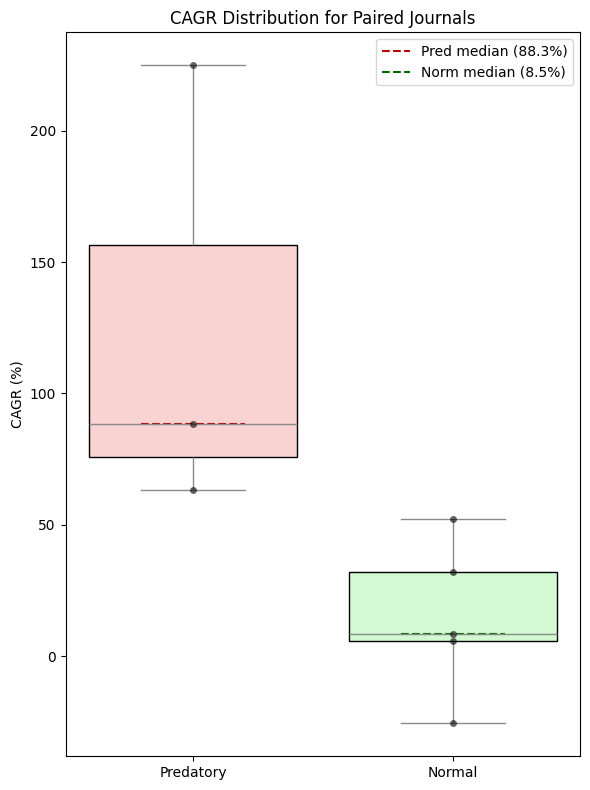

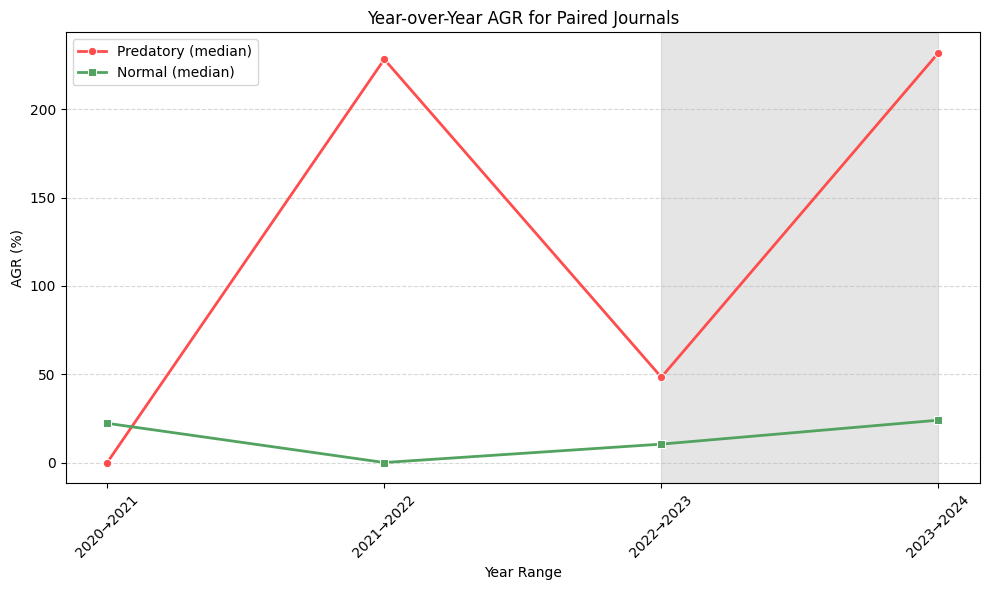

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

START_YEAR = 2020
END_YEAR   = 2024
YEARS      = list(range(START_YEAR, END_YEAR + 1))
RANGES     = [f"{y}→{y+1}" for y in YEARS[:-1]]     
SHEET     = 'Sheet1'

journal_pairs = [
    ("International Journal of Applied Research in Social Sciences", "Discover Applied Sciences"),
    ("International Journal of Management & Entrepreneurship Research", "Journal of Business and Management Studies"),
    ("International Medical Science Research Journal", "Nature Machine Intelligence"),
    ("Finance & Accounting Research Journal", "Finance, Accounting and Business Analysis"),
    ("International Journal of Science and Research Archive", "SciPost Physics Core"),
]
pred_journals = [p for p, _ in journal_pairs]
reg_journals  = [r for _, r in journal_pairs]

def load_pivot(path):
    df = pd.read_excel(path, sheet_name=SHEET)
    df = df.rename(columns={'paper count':'paper_count'})
    df['year'] = df['year'].astype(int)
    df = df[df['year'].between(START_YEAR, END_YEAR)]
    piv = df.groupby(['Journal','year'])['paper_count'].sum().unstack('year').fillna(0)
  
    for y, rng in zip(range(START_YEAR, END_YEAR), RANGES):
        mask = piv[y] > 0
        piv.loc[mask, rng] = ((piv.loc[mask, y+1] - piv.loc[mask, y]) / piv.loc[mask, y]) * 100
    piv.replace([np.inf, -np.inf], np.nan, inplace=True)
    return piv

def compute_cagr(piv):
    cagr = {}
    for journal, row in piv.iterrows():
        yrs = [y for y in YEARS if y in row.index]
        if len(yrs) >= 2 and row[yrs[0]] > 0:
            v1, v2 = row[yrs[0]], row[yrs[-1]]
            cagr[journal] = ((v2/v1)**(1/(yrs[-1]-yrs[0])) - 1) * 100
        else:
            cagr[journal] = np.nan
    return pd.Series(cagr)

pred_piv = load_pivot(PRED_FILE).loc[pred_journals]
reg_piv  = load_pivot(REG_FILE).loc[reg_journals]

pred_cagr = compute_cagr(pred_piv).loc[pred_journals]
reg_cagr  = compute_cagr(reg_piv).loc[reg_journals]

plt.figure(figsize=(6,8))
data = pd.DataFrame({
    'CAGR': np.concatenate([pred_cagr.dropna().values, reg_cagr.dropna().values]),
    'Type': ['Predatory'] * pred_cagr.dropna().size + ['Normal'] * reg_cagr.dropna().size
})
sns.boxplot(x='Type', y='CAGR', data=data,
            palette={'Predatory':'#ffcccc','Normal':'#ccffcc'},
            boxprops={'edgecolor':'black'})
sns.swarmplot(x='Type', y='CAGR', data=data, color='k', alpha=0.6, size=5)

med_pred = pred_cagr.median()
med_reg  = reg_cagr.median()
plt.hlines(med_pred, -0.2, 0.2, colors='#b30000', linestyles='--',
           label=f'Pred median ({med_pred:.1f}%)')
plt.hlines(med_reg, 0.8, 1.2, colors='#006600', linestyles='--',
           label=f'Norm median ({med_reg:.1f}%)')

plt.title("CAGR Distribution for Paired Journals")
plt.ylabel("CAGR (%)")
plt.xlabel("")
plt.legend()
plt.tight_layout()
# plt.savefig("CAGR_pairs_distribution.png", dpi=300)
plt.show()

median_pred_agr = pred_piv[RANGES].median(skipna=True)
median_reg_agr  = reg_piv[RANGES].median(skipna=True)

plt.figure(figsize=(10,6))
sns.lineplot(x=RANGES, y=median_pred_agr.values, marker='o', linewidth=2,
             label='Predatory (median)', color='#ff4c4c')
sns.lineplot(x=RANGES, y=median_reg_agr.values, marker='s', linewidth=2,
             label='Normal (median)', color='#52a360')

plt.axvspan(RANGES[-2], RANGES[-1], color='gray', alpha=0.2)
plt.title("Year-over-Year AGR for Paired Journals")
plt.xlabel("Year Range")
plt.ylabel("AGR (%)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
# plt.savefig("AGR_pairs_comparison.png", dpi=300)
plt.show()


Venue counts and topic diffusion

In [4]:
import pandas as pd

good_file = "data/norm/dataset/csv/papers.csv"
bad_file = "data/pred/dataset/csv/papers.csv"

good_df = pd.read_csv(good_file)
bad_df  = pd.read_csv(bad_file)

good_df['publisher'] = good_df['publisher'].fillna('').str.strip().str.lower()
bad_df['publisher']  = bad_df['publisher'].fillna('').str.strip().str.lower()

distinct_good = good_df[good_df['publisher'] != '']['publisher'].nunique()
distinct_bad  = bad_df [bad_df ['publisher'] != '']['publisher'].nunique()

print(f"Distinct journals in Regular dataset:   {distinct_good}")
print(f"Distinct journals in Predatory dataset: {distinct_bad}")


Distinct journals in Regular dataset:   3292
Distinct journals in Predatory dataset: 2597


In [5]:
for df in [good_df, bad_df]:
    df['publisher'] = df['publisher'].fillna('').str.strip().str.lower()
    df['topic_title_abs_30'] = df['topic_title_abs_30'].fillna('Unknown')

good_topic_to_venues = good_df.groupby('topic_title_abs_30')['publisher'].nunique()
bad_topic_to_venues  = bad_df.groupby('topic_title_abs_30')['publisher'].nunique()

good_avg_venues_per_topic = good_topic_to_venues.mean()
bad_avg_venues_per_topic  = bad_topic_to_venues.mean()

print(f"Average number of journals per topic (Regular):   {good_avg_venues_per_topic:.2f}")
print(f"Average number of journals per topic (Predatory): {bad_avg_venues_per_topic:.2f}")


Average number of journals per topic (Regular):   130.26
Average number of journals per topic (Predatory): 109.32


In [6]:
import pandas as pd

pa_good = pd.read_csv("data/norm/dataset/csv/paper_authors.csv")
pa_bad  = pd.read_csv("data/pred/dataset/csv/paper_authors.csv")

for df in [good_df, bad_df]:
    df['publisher'] = df['publisher'].fillna('').str.strip().str.lower()

good_paper2pub = good_df[good_df['publisher'] != ''][['id', 'publisher']].drop_duplicates()
bad_paper2pub  = bad_df [bad_df ['publisher'] != ''][['id', 'publisher']].drop_duplicates()

good_merged = pa_good.merge(good_paper2pub, left_on='paper_id', right_on='id')
bad_merged  = pa_bad.merge(bad_paper2pub,  left_on='paper_id', right_on='id')

good_author2journals = good_merged.groupby('author_id')['publisher'].nunique()
bad_author2journals  = bad_merged.groupby('author_id')['publisher'].nunique()

good_avg = good_author2journals.mean()
bad_avg  = bad_author2journals.mean()

print(f"Average number of journals per author (Regular):   {good_avg:.2f}")
print(f"Average number of journals per author (Predatory): {bad_avg:.2f}")


Average number of journals per author (Regular):   1.65
Average number of journals per author (Predatory): 1.46


In [7]:
import numpy as np
import pandas as pd
from scipy import stats

good_topic_to_venues = good_df.groupby('topic_title_abs_30')['publisher'].nunique()
bad_topic_to_venues  = bad_df.groupby('topic_title_abs_30')['publisher'].nunique()

def cohen_d(x, y):
    x = np.asarray(x, float); y = np.asarray(y, float)
    nx, ny = len(x), len(y)
    vx, vy = x.var(ddof=1), y.var(ddof=1)
    s = np.sqrt(((nx-1)*vx + (ny-1)*vy) / (nx+ny-2))
    return (x.mean() - y.mean()) / s

def cliffs_delta(x, y):
    x = np.asarray(x, float); y = np.asarray(y, float)
    greater = 0; smaller = 0
    for xi in x:
        greater += np.sum(xi > y)
        smaller += np.sum(xi < y)
    n1, n2 = len(x), len(y)
    return (greater - smaller) / (n1 * n2)

def bootstrap_ci(x, y, stat_fn, n_boot=10000, alpha=0.05, random_state=0):
    rng = np.random.default_rng(random_state)
    x = np.asarray(x, float); y = np.asarray(y, float)
    stats_boot = []
    nx, ny = len(x), len(y)
    for _ in range(n_boot):
        xb = rng.choice(x, size=nx, replace=True)
        yb = rng.choice(y, size=ny, replace=True)
        stats_boot.append(stat_fn(xb, yb))
    lo, hi = np.percentile(stats_boot, [100*alpha/2, 100*(1-alpha/2)])
    return lo, hi

def normality_and_variance_tests(x, y):
    sw_x = stats.shapiro(x) if len(x) >= 3 and len(x) <= 5000 else (np.nan, np.nan)
    sw_y = stats.shapiro(y) if len(y) >= 3 and len(y) <= 5000 else (np.nan, np.nan)
    lev  = stats.levene(x, y, center='median')
    return sw_x, sw_y, lev

def choose_and_test(x, y):
    x = np.asarray(x, float); y = np.asarray(y, float)
    sw_x, sw_y, lev = normality_and_variance_tests(x, y)
    normal_like = (not np.isnan(sw_x[1]) and sw_x[1] > 0.05) and (not np.isnan(sw_y[1]) and sw_y[1] > 0.05)
    if normal_like:
        tstat, p = stats.ttest_ind(x, y, equal_var=False)  # Welch
        test_used = "Welch's t-test"
        effect = ("Cohen's d", cohen_d(x, y))
        ci = bootstrap_ci(x, y, lambda a,b: a.mean()-b.mean())
        est_label = "mean difference (good - bad)"
        est_value = x.mean() - y.mean()
    else:
        u, p = stats.mannwhitneyu(x, y, alternative='two-sided')
        test_used = "Mann–Whitney U"
        effect = ("Cliff's delta", cliffs_delta(x, y))
        ci = bootstrap_ci(x, y, lambda a,b: np.median(a)-np.median(b))
        est_label = "median difference (good - bad)"
        est_value = np.median(x) - np.median(y)
    return {
        "test": test_used,
        "p_value": float(p),
        "norm_sw_p_good": None if np.isnan(sw_x[1]) else float(sw_x[1]),
        "norm_sw_p_bad":  None if np.isnan(sw_y[1]) else float(sw_y[1]),
        "levene_p": float(lev.pvalue),
        "estimate_label": est_label,
        "estimate": float(est_value),
        "ci_low": float(ci[0]),
        "ci_high": float(ci[1]),
        "effect_name": effect[0],
        "effect_size": float(effect[1]),
        "n_good": int(len(x)),
        "n_bad": int(len(y)),
        "mean_good": float(np.mean(x)),
        "mean_bad": float(np.mean(y)),
        "median_good": float(np.median(x)),
        "median_bad": float(np.median(y)),
    }

res_topic = choose_and_test(good_topic_to_venues.values, bad_topic_to_venues.values)
res_author = choose_and_test(good_author2journals.values, bad_author2journals.values)

def benjamini_hochberg(pvals):
    pvals = np.asarray(pvals, float)
    m = len(pvals)
    order = np.argsort(pvals)
    ranked = pvals[order]
    q = np.empty_like(ranked)
    prev = 1.0
    for i in range(m, 0, -1):
        q_i = min(prev, ranked[i-1] * m / i)
        q[i-1] = q_i
        prev = q_i
    q_adj = np.empty_like(q)
    q_adj[order] = q
    return q_adj

pvals = [res_topic["p_value"], res_author["p_value"]]
qvals = benjamini_hochberg(pvals)
res_topic["q_value"] = float(qvals[0])
res_author["q_value"] = float(qvals[1])

def pretty_print(title, res):
    print(f"\n=== {title} ===")
    print(f"n_good={res['n_good']}  n_bad={res['n_bad']}")
    print(f"Normality p (Shapiro): good={res['norm_sw_p_good']}, bad={res['norm_sw_p_bad']}")
    print(f"Levene variance p: {res['levene_p']:.4g}")
    print(f"Test used: {res['test']}")
    print(f"p-value = {res['p_value']:.4g} | q-value(FDR) = {res['q_value']:.4g}")
    print(f"{res['estimate_label']}: {res['estimate']:.3f}  (95% CI {res['ci_low']:.3f}, {res['ci_high']:.3f})")
    print(f"{res['effect_name']}: {res['effect_size']:.3f}")
    print(f"Means: good={res['mean_good']:.3f}, bad={res['mean_bad']:.3f} | "
          f"Medians: good={res['median_good']:.3f}, bad={res['median_bad']:.3f}")

pretty_print("Number of journals per topic (good vs. bad)", res_topic)
pretty_print("Number of unique journals per author (good vs. bad)", res_author)


from scipy import stats
import numpy as np

def brunner_munzel_test(x, y):
    try:
        from scipy.stats import brunner_munzel
        stat, p = brunner_munzel(x, y, alternative='two-sided')
        return stat, p
    except Exception:
        u, p = stats.mannwhitneyu(x, y, alternative='two-sided')
        return u, p

bm_topic = brunner_munzel_test(good_topic_to_venues.values, bad_topic_to_venues.values)
bm_author = brunner_munzel_test(good_author2journals.values, bad_author2journals.values)
print(f"Brunner–Munzel (number of subject journals) p={bm_topic[1]:.4g}")
print(f"Brunner–Munzel (number of unique author journals) p={bm_author[1]:.4g}")

def permutation_pvalue(x, y, stat_fn=lambda a,b: np.mean(a)-np.mean(b), n_perm=10000, seed=0):
    rng = np.random.default_rng(seed)
    x = np.asarray(x, float); y = np.asarray(y, float)
    obs = stat_fn(x, y)
    z = np.concatenate([x, y])
    nx = len(x)
    cnt = 0
    for _ in range(n_perm):
        rng.shuffle(z)
        xp, yp = z[:nx], z[nx:]
        if abs(stat_fn(xp, yp)) >= abs(obs):
            cnt += 1
    p = (cnt + 1) / (n_perm + 1)
    return obs, p

obs_topic, p_perm_topic = permutation_pvalue(
    good_topic_to_venues.values, bad_topic_to_venues.values,
    stat_fn=lambda a,b: np.median(a)-np.median(b)
)
obs_author, p_perm_author = permutation_pvalue(
    good_author2journals.values, bad_author2journals.values,
    stat_fn=lambda a,b: np.median(a)-np.median(b)
)
print(f"Permutation test (topic: median difference) estimate={obs_topic:.3f}, p={p_perm_topic:.4g}")
print(f"Permutation test (author: median difference) estimate={obs_author:.3f}, p={p_perm_author:.4g}")

def hodges_lehmann_ci(x, y, alpha=0.05):
    diffs = np.subtract.outer(np.asarray(x, float), np.asarray(y, float)).ravel()
    est = np.median(diffs)
    lo, hi = np.percentile(diffs, [100*alpha/2, 100*(1-alpha/2)])
    return est, lo, hi

hl_topic = hodges_lehmann_ci(good_topic_to_venues.values, bad_topic_to_venues.values)
hl_author = hodges_lehmann_ci(good_author2journals.values, bad_author2journals.values)
print(f"Hodges–Lehmann (topic): estimate={hl_topic[0]:.3f}, 95%CI=({hl_topic[1]:.3f},{hl_topic[2]:.3f})")
print(f"Hodges–Lehmann (author): estimate={hl_author[0]:.3f}, 95%CI=({hl_author[1]:.3f},{hl_author[2]:.3f})")



=== Number of journals per topic (good vs. bad) ===
n_good=31  n_bad=31
Normality p (Shapiro): good=1.6942654568387251e-06, bad=1.4360164163682512e-05
Levene variance p: 0.9198
Test used: Mann–Whitney U
p-value = 0.151 | q-value(FDR) = 0.151
median difference (good - bad): 30.000  (95% CI -41.000, 61.000)
Cliff's delta: 0.213
Means: good=130.258, bad=109.323 | Medians: good=88.000, bad=58.000

=== Number of unique journals per author (good vs. bad) ===
n_good=18061  n_bad=11001
Normality p (Shapiro): good=None, bad=None
Levene variance p: 3.718e-08
Test used: Mann–Whitney U
p-value = 1.285e-07 | q-value(FDR) = 2.569e-07
median difference (good - bad): 0.000  (95% CI 0.000, 0.000)
Cliff's delta: 0.024
Means: good=1.651, bad=1.461 | Medians: good=1.000, bad=1.000
Brunner–Munzel (number of subject journals) p=0.151
Brunner–Munzel (number of unique author journals) p=1.285e-07
Permutation test (topic: median difference) estimate=30.000, p=0.2254
Permutation test (author: median difference

<h2>Data from Crossref</h2>

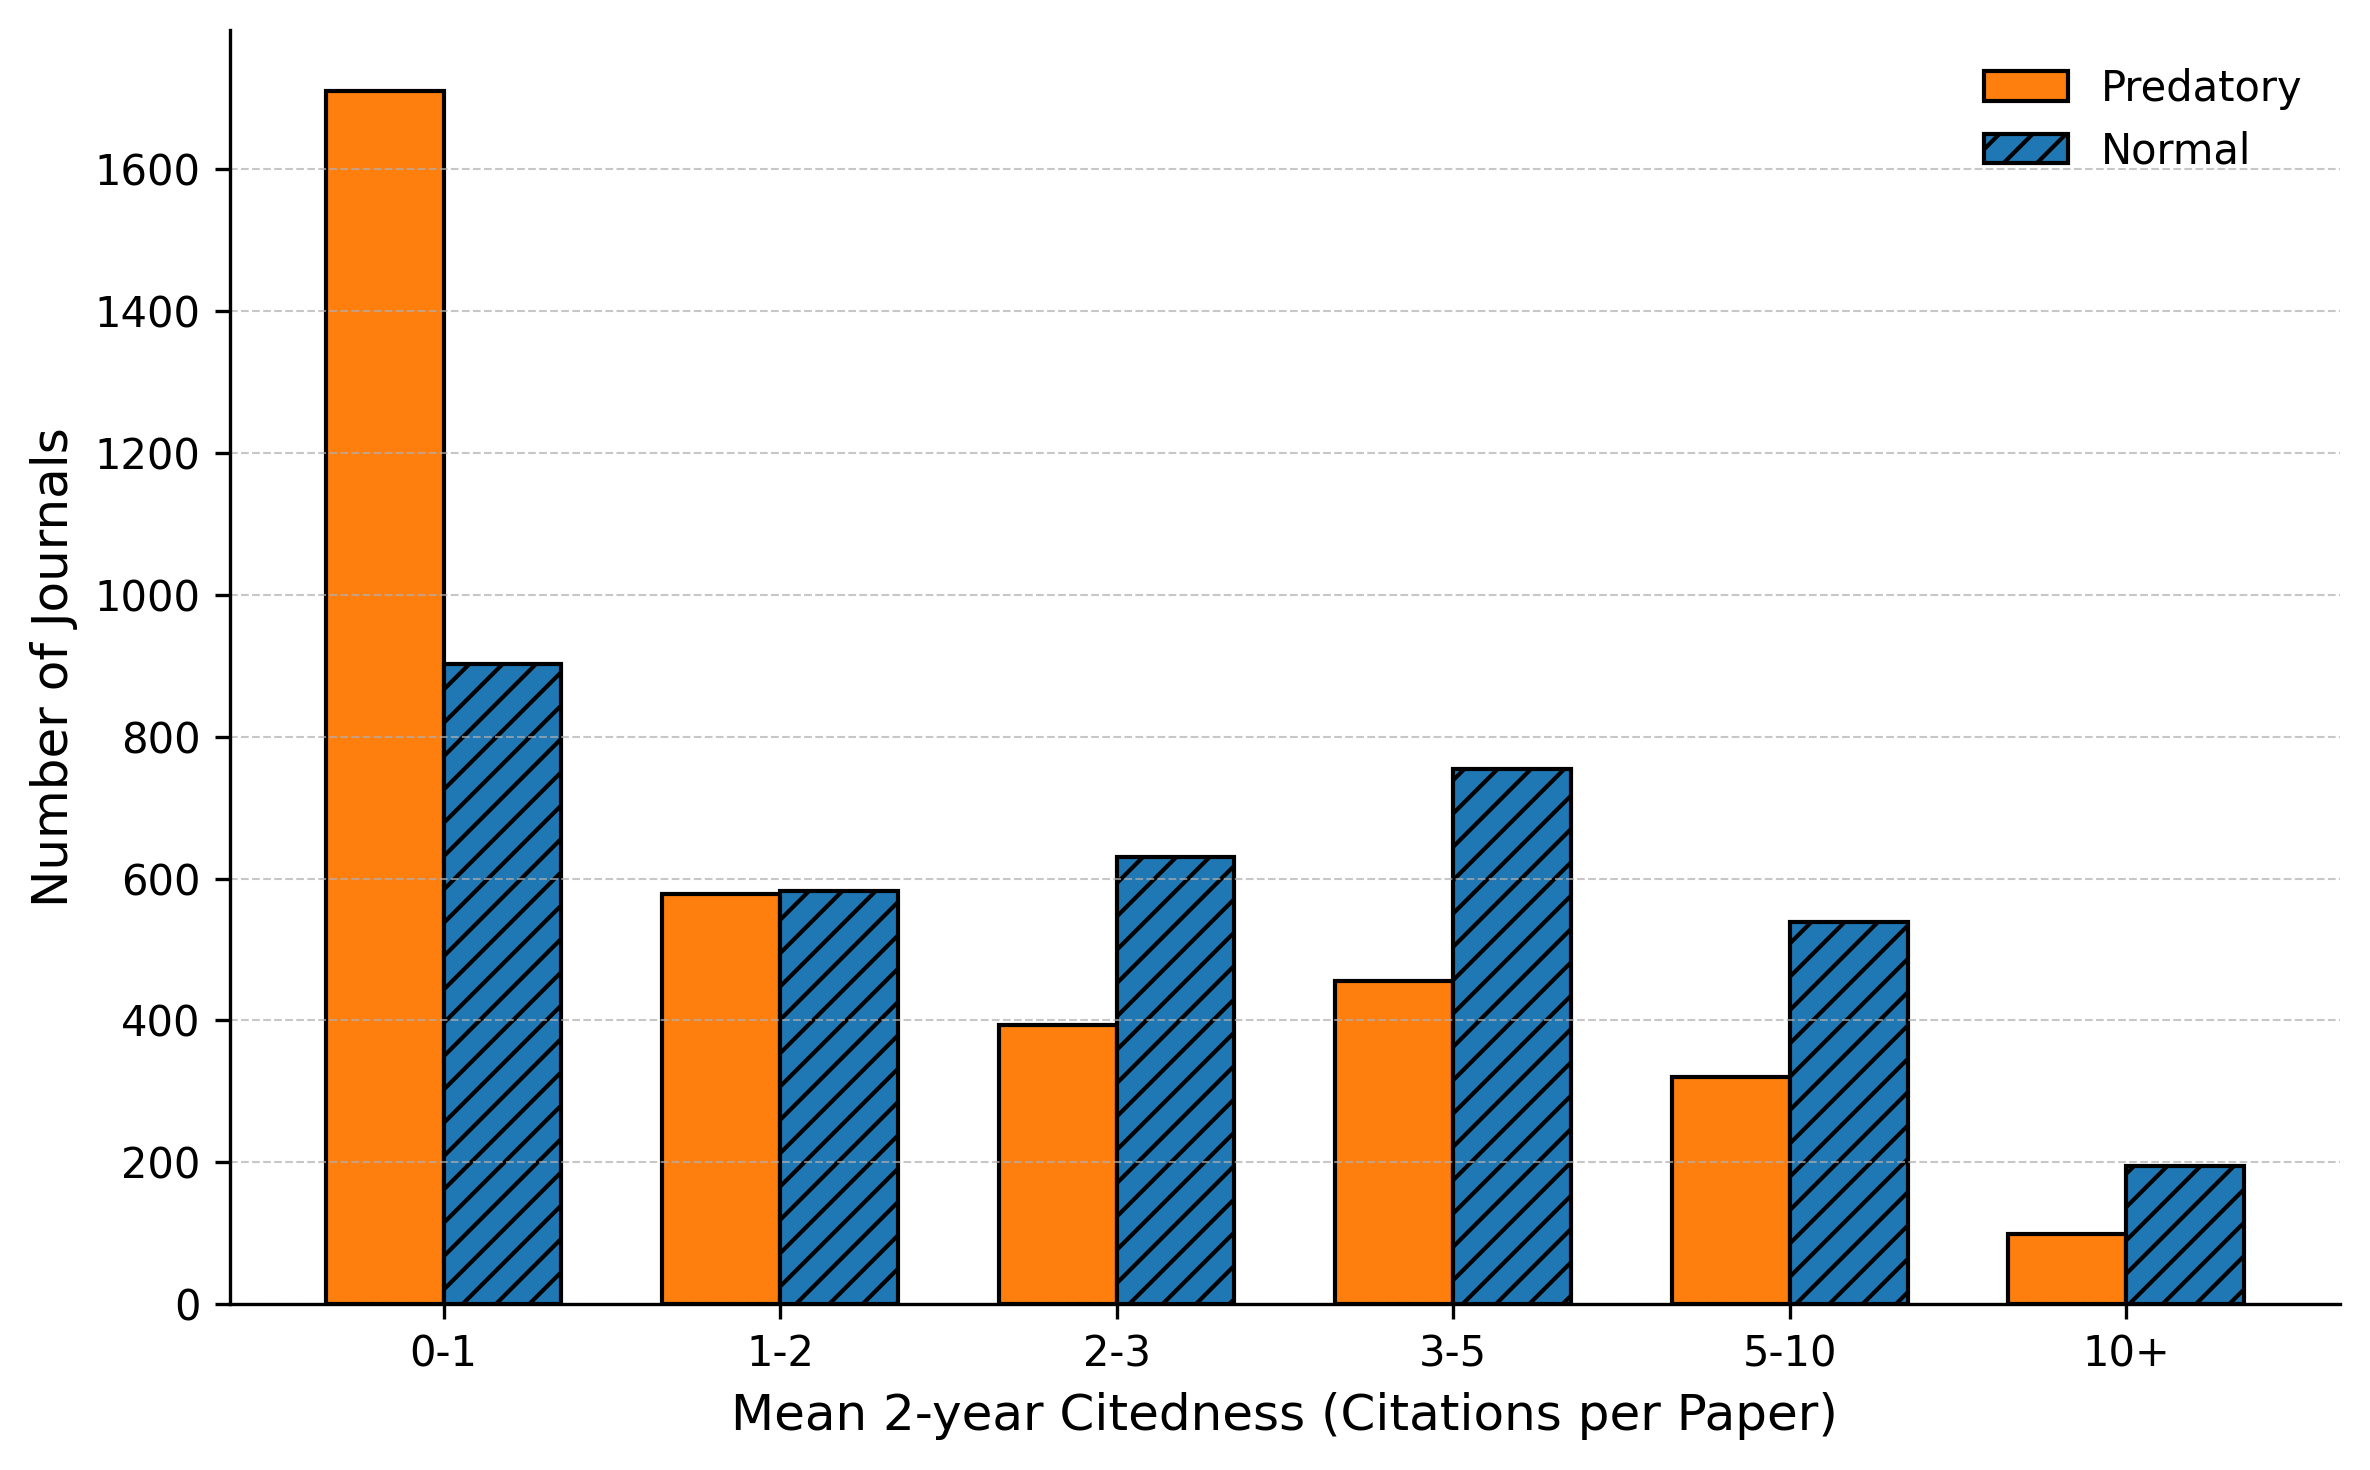

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pred = pd.read_csv("data/pred/metadata/pred_issn_metrics.csv", dtype=str)
norm = pd.read_csv("data/norm/metadata/norm_issn_metrics.csv", dtype=str)

pred["mean_2yr_citedness"] = pd.to_numeric(pred["mean_2yr_citedness"], errors="coerce")
norm["mean_2yr_citedness"] = pd.to_numeric(norm["mean_2yr_citedness"], errors="coerce")

bins = [0, 1, 2, 3, 5, 10, np.inf]
labels = ["0-1", "1-2", "2-3", "3-5", "5-10", "10+"]

pred_bins = pd.cut(pred["mean_2yr_citedness"].fillna(0), bins=bins, labels=labels, right=False)
norm_bins = pd.cut(norm["mean_2yr_citedness"].fillna(0), bins=bins, labels=labels, right=False)

pred_counts = pred_bins.value_counts().sort_index()
norm_counts = norm_bins.value_counts().sort_index()

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
ax.bar(x - width/2, pred_counts, width,
       label="Predatory", color='tab:orange', edgecolor='black')
ax.bar(x + width/2, norm_counts, width,
       label="Normal",    color='tab:blue',   edgecolor='black', hatch='///')

ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=10)
ax.set_xlabel("Mean 2‐year Citedness (Citations per Paper)", fontsize=12)
ax.set_ylabel("Number of Journals", fontsize=12)
ax.tick_params(axis='y', labelsize=10)
ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon=False, fontsize=10, loc='upper right')

plt.tight_layout()
plt.show()


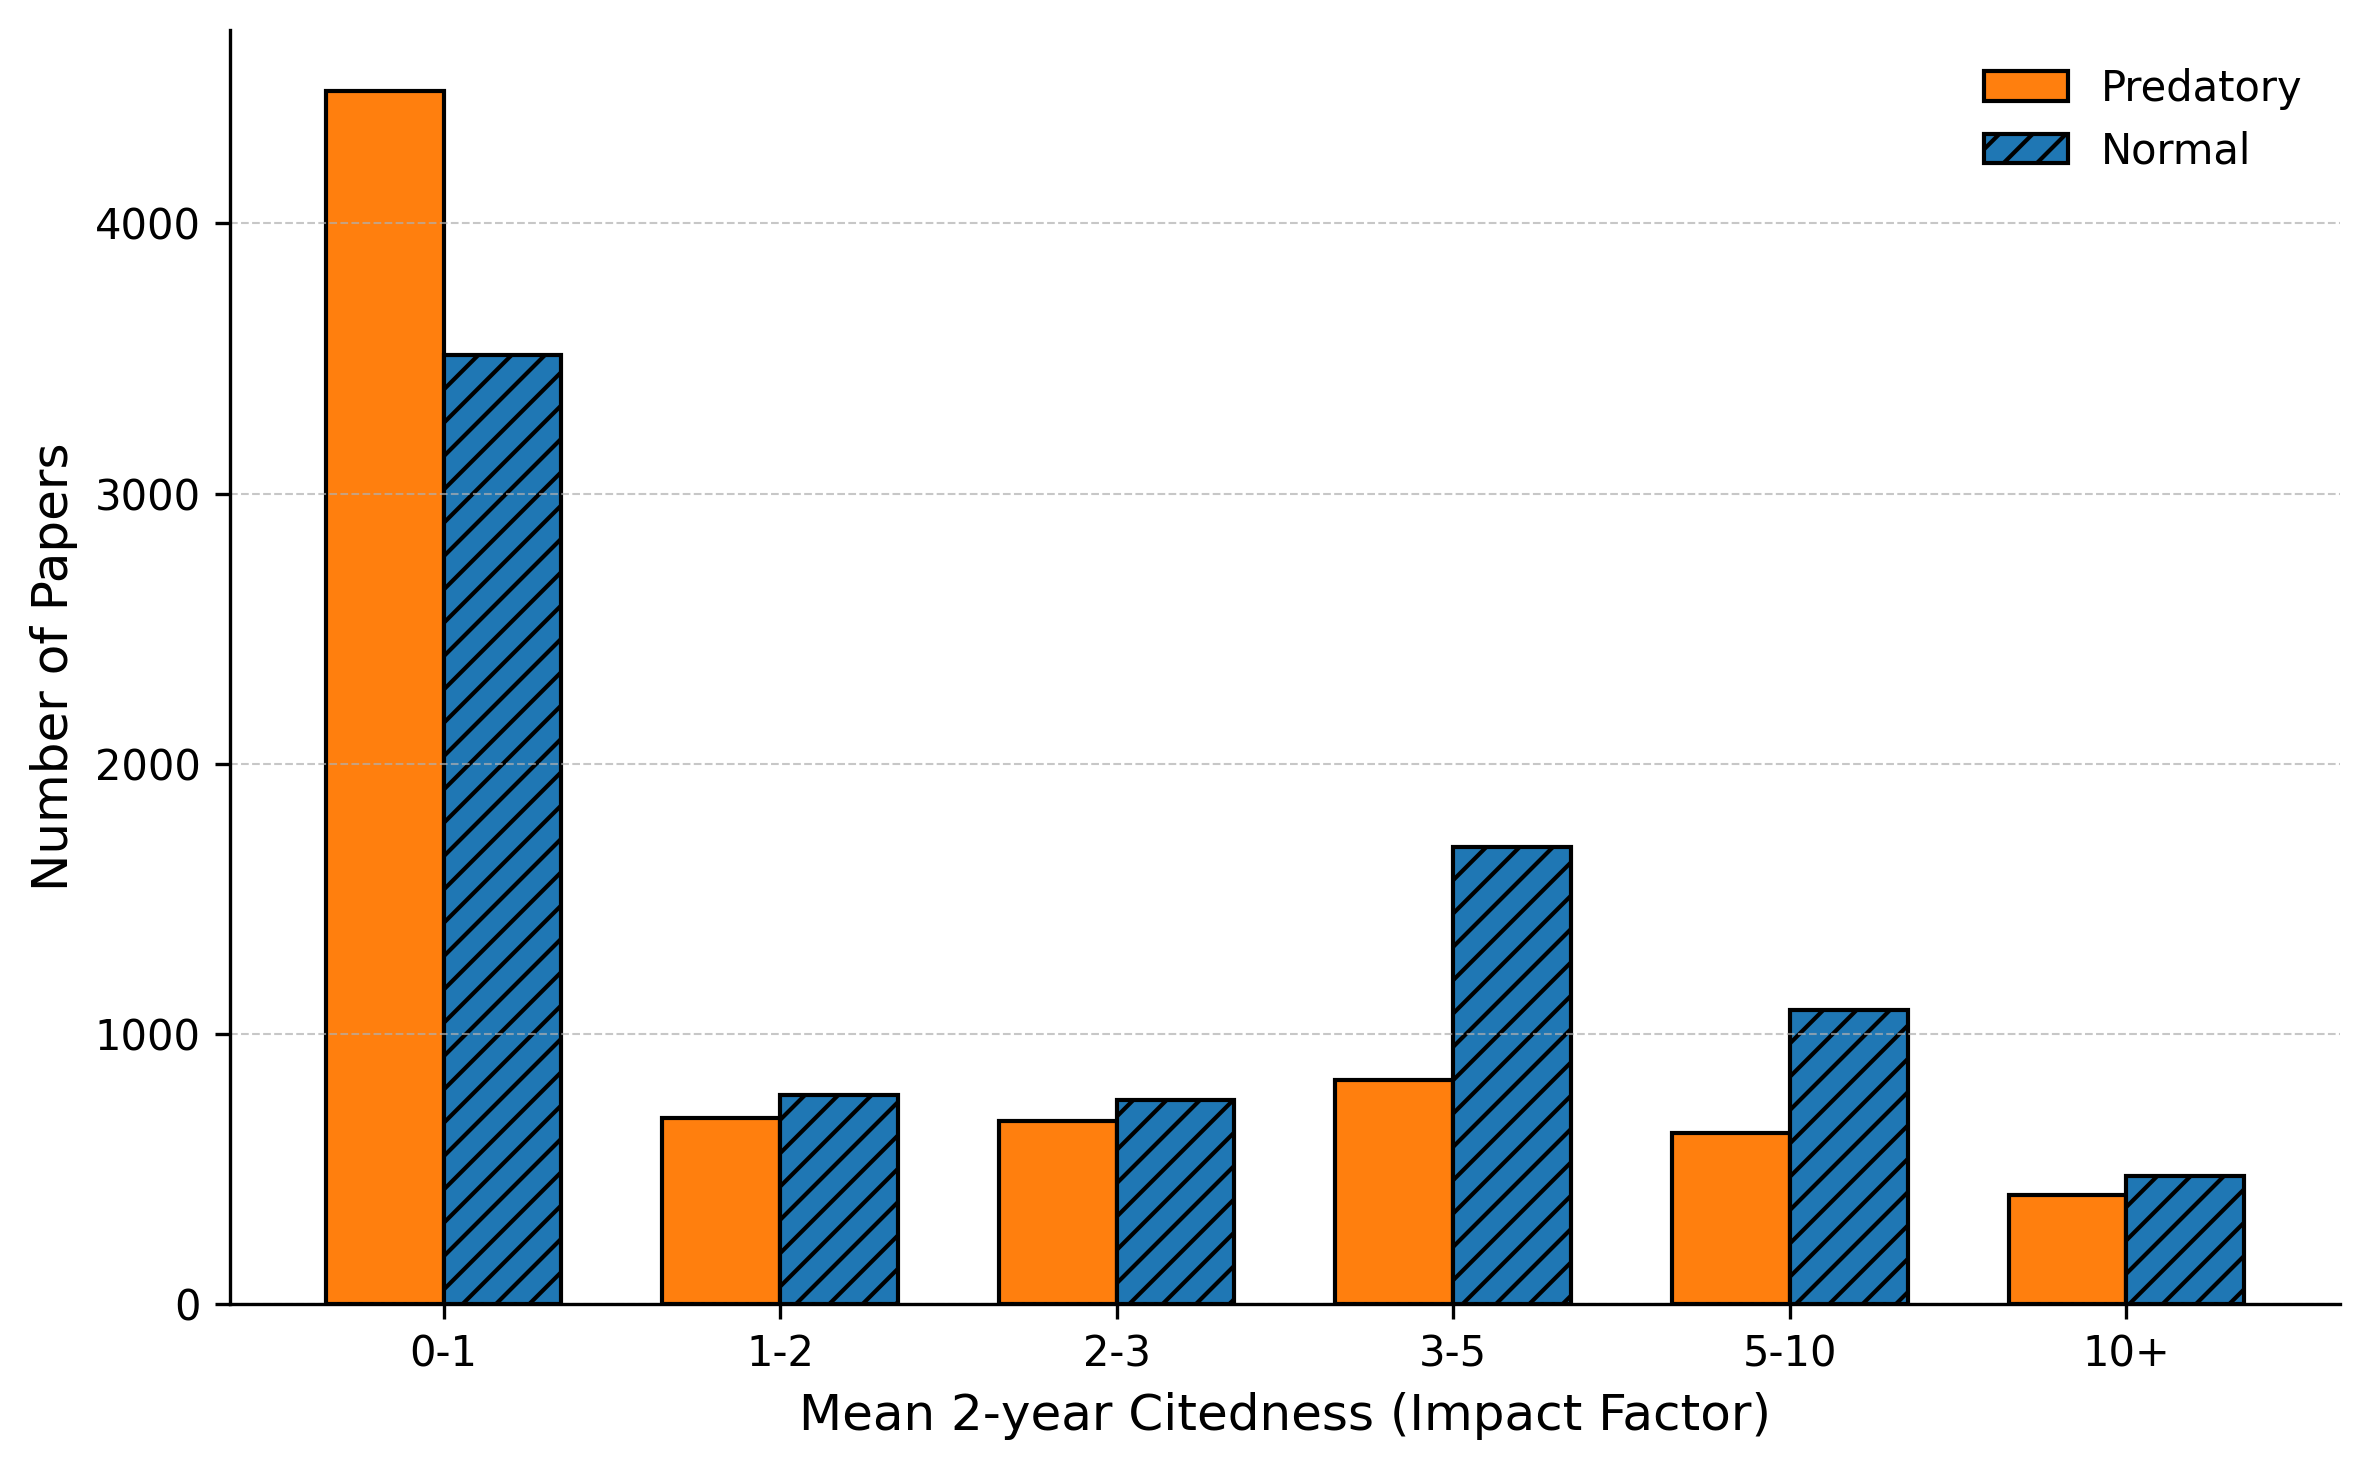

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pred_meta = pd.read_csv("data/pred/metadata/pred_crossref_meta.csv", dtype=str)
norm_meta = pd.read_csv("data/norm/metadata/norm_crossref_meta.csv", dtype=str)
pred_metrics = pd.read_csv("data/pred/metadata/pred_issn_metrics.csv", dtype=str)
norm_metrics = pd.read_csv("data/norm/metadata/norm_issn_metrics.csv", dtype=str)

# Convert mean_2yr_citedness to numeric
pred_metrics["mean_2yr_citedness"] = pd.to_numeric(pred_metrics["mean_2yr_citedness"], errors="coerce")
norm_metrics["mean_2yr_citedness"] = pd.to_numeric(norm_metrics["mean_2yr_citedness"], errors="coerce")

# Create mapping: ISSN -> mean_2yr_citedness 
pred_map = dict(zip(pred_metrics["issn"], pred_metrics["mean_2yr_citedness"]))
norm_map = dict(zip(norm_metrics["issn"], norm_metrics["mean_2yr_citedness"]))

pred_meta["issn_first"] = pred_meta["issn"].str.split(",").str[0].str.strip()
norm_meta["issn_first"] = norm_meta["issn"].str.split(",").str[0].str.strip()

pred_meta["mean2"] = pred_meta["issn_first"].map(pred_map).fillna(0)
norm_meta["mean2"] = norm_meta["issn_first"].map(norm_map).fillna(0)

# Define bins and labels
bins = [0, 1, 2, 3, 5, 10, np.inf]
labels = ["0-1", "1-2", "2-3", "3-5", "5-10", "10+"]

# Bin the paper-level citedness 
pred_paper_bins = pd.cut(pred_meta["mean2"], bins=bins, labels=labels, right=False)
norm_paper_bins = pd.cut(norm_meta["mean2"], bins=bins, labels=labels, right=False)

pred_paper_counts = pred_paper_bins.value_counts().sort_index()
norm_paper_counts = norm_paper_bins.value_counts().sort_index()

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
ax.bar(x - width/2, pred_paper_counts, width,
       label="Predatory", color='tab:orange', edgecolor='black')
ax.bar(x + width/2, norm_paper_counts, width,
       label="Normal",    color='tab:blue',   edgecolor='black', hatch='///')

ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=10)
ax.set_xlabel("Mean 2‑year Citedness (Impact Factor)", fontsize=12)
ax.set_ylabel("Number of Papers", fontsize=12)
ax.tick_params(axis='y', labelsize=10)
ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon=False, fontsize=10, loc='upper right')

plt.tight_layout()
plt.show()


Find Journal overlap on cited paper only

In [10]:
import pandas as pd

pred_meta = pd.read_csv("data/pred/dataset/csv/papers.csv", dtype=str)
norm_meta = pd.read_csv("data/norm/dataset/csv/papers.csv", dtype=str)
pred_cit = pd.read_csv("data/pred/dataset/csv/citations.csv", dtype=str)
norm_cit = pd.read_csv("data/norm/dataset/csv/citations.csv", dtype=str)

cited_pred = set(pred_cit['cited_paper_id'])
cited_norm = set(norm_cit['cited_paper_id'])
pred_meta = pred_meta[pred_meta['id'].isin(cited_pred)]
norm_meta = norm_meta[norm_meta['id'].isin(cited_norm)]

def clean_publisher(df):
    df = df[~df['publisher'].isna()]
    df = df[df['publisher'].str.strip() != '']
    df = df[~df['publisher'].str.lower().eq('null')]
    return df

pred_meta = clean_publisher(pred_meta)
norm_meta = clean_publisher(norm_meta)

shared_journals = set(pred_meta['publisher']) & set(norm_meta['publisher'])

shared_pred = (
    pred_meta[pred_meta['publisher'].isin(shared_journals)]
    .loc[:, ['publisher', 'id', 'title']]
    .assign(dataset='Predatory')
    .rename(columns={'publisher': 'journal'})
)
shared_norm = (
    norm_meta[norm_meta['publisher'].isin(shared_journals)]
    .loc[:, ['publisher', 'id', 'title']]
    .assign(dataset='Normal')
    .rename(columns={'publisher': 'journal'})
)

pred_votes = pd.read_csv("data/pred/dataset/csv/vote_results.csv", dtype=str)
norm_votes = pd.read_csv("data/norm/dataset/csv/vote_results.csv", dtype=str)
pred_votes = pred_votes.drop_duplicates(subset=['paper_id'], keep='first')
norm_votes = norm_votes.drop_duplicates(subset=['paper_id'], keep='first')

pred_merged = shared_pred.merge(
    pred_votes[['paper_id', 'final_decision']],
    left_on='id', right_on='paper_id', how='left'
).drop(columns='paper_id').rename(columns={'final_decision': 'decision'})

norm_merged = shared_norm.merge(
    norm_votes[['paper_id', 'final_decision']],
    left_on='id', right_on='paper_id', how='left'
).drop(columns='paper_id').rename(columns={'final_decision': 'decision'})

final_df = pd.concat([pred_merged, norm_merged], ignore_index=True)

final_df = final_df.drop_duplicates(subset=['id'])

final_df.to_csv("data/shared_journal_papers.csv", index=False)



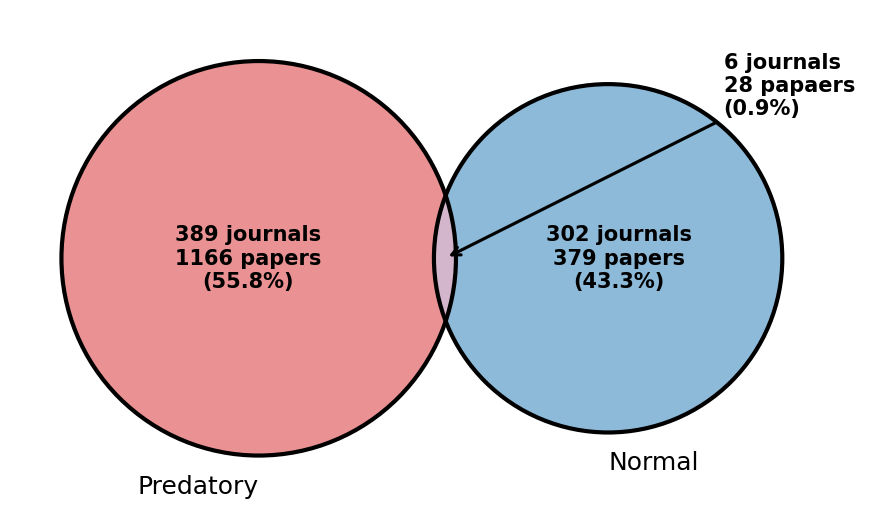

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles

pred_meta = pred_meta[pred_meta['id'].isin(pred_cit['cited_paper_id'])]
norm_meta = norm_meta[norm_meta['id'].isin(norm_cit['cited_paper_id'])]

invalid = {"Unknown", "null", ""}
pred_meta = pred_meta[~pred_meta['publisher'].isin(invalid)]
norm_meta = norm_meta[~norm_meta['publisher'].isin(invalid)]

A = set(pred_meta['publisher'])
B = set(norm_meta['publisher'])
onlyA = A - B
onlyB = B - A
shared = A & B

shared_df = pd.read_csv("data/shared_journal_papers.csv", dtype=str)
auto_pred = {j for j in shared if shared_df[shared_df['journal'] == j]['decision'].eq('AI').all()}
auto_norm = {j for j in shared if shared_df[shared_df['journal'] == j]['decision'].eq('Human').all()}
manual_shared = shared - auto_pred - auto_norm

new_onlyA = onlyA.union(auto_pred)
new_onlyB = onlyB.union(auto_norm)
new_shared = manual_shared

nA, nB, nAB = len(new_onlyA), len(new_onlyB), len(new_shared)
pred_p = pred_meta[pred_meta['publisher'].isin(new_onlyA)].shape[0]
norm_p = norm_meta[norm_meta['publisher'].isin(new_onlyB)].shape[0]
shared_p = (pred_meta[pred_meta['publisher'].isin(new_shared)].shape[0] +
            norm_meta[norm_meta['publisher'].isin(new_shared)].shape[0])
total_j = nA + nB + nAB
pct = lambda x: f"{x / total_j * 100:.1f}%"

fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
v = venn2(subsets=(nA, nB, nAB),
          set_labels=("Predatory", "Normal"),
          set_colors=('tab:red', 'tab:blue'),
          alpha=0.5, ax=ax)
venn2_circles((nA, nB, nAB), linewidth=2, color='black', ax=ax)
for lbl in v.subset_labels:
    if lbl:
        lbl.set_text("")
pos10 = v.get_label_by_id('10').get_position()
ax.text(*pos10, f"{nA} journals\n{pred_p} papers\n({pct(nA)})", ha='center', va='center', fontsize=10, fontweight='bold')
pos01 = v.get_label_by_id('01').get_position()
ax.text(*pos01, f"{nB} journals\n{norm_p} papers\n({pct(nB)})", ha='center', va='center', fontsize=10, fontweight='bold')
pos11 = v.get_label_by_id('11').get_position()
annot_xy = (pos11[0] + 0.6, pos11[1] + 0.3)
ax.annotate(f"{nAB} journals\n{shared_p} papaers\n({pct(nAB)})", xy=pos11, xytext=annot_xy,
            arrowprops=dict(arrowstyle="->", lw=1.5, color="black"),
            ha='left', va='bottom', fontsize=10, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()


In [12]:

metrics = pd.concat([pred_metrics, norm_metrics], ignore_index=True)

metrics = (metrics
           .dropna(subset=['display_name'])
           .drop_duplicates(subset=['display_name'])
           .set_index('display_name')
           )

for col in ['h_index', 'i10_index', 'mean_2yr_citedness']:
    metrics[col] = pd.to_numeric(metrics[col], errors='coerce')
metrics['is_oa'] = metrics['is_oa'].map({'True': True, 'False': False})
metrics['is_core'] = metrics['is_core'].map({'True': True, 'False': False})

def summarize_journals(jset):
    dfm = metrics.loc[metrics.index.intersection(jset)]
    return {
        'journal_count': len(jset),
        'mean_h_index': dfm['h_index'].mean(),
        'median_h_index': dfm['h_index'].median(),
        'mean_i10_index': dfm['i10_index'].mean(),
        'mean_2yr_citedness': dfm['mean_2yr_citedness'].mean(),
        'open_access_rate (%)': dfm['is_oa'].mean() * 100,
        'core_journal_rate (%)': dfm['is_core'].mean() * 100
    }

quality = pd.DataFrame([
    summarize_journals(new_onlyA),
    summarize_journals(new_onlyB),
    summarize_journals(new_shared)
], index=['Pred set', 'Norm set', 'Shared']).round(2)

print("\nJournal‐Name‐Based Quality Metrics:")
quality



Journal‐Name‐Based Quality Metrics:


,journal_count,mean_h_index,median_h_index,mean_i10_index,mean_2yr_citedness,open_access_rate (%),core_journal_rate (%)
Pred set,389,55.09,26.0,2043.18,3.11,37.21,58.91
Norm set,302,183.45,117.0,9919.98,4.49,33.11,98.65
Shared,6,245.80,255.0,47159.60,3.89,100.00,100.00


In [13]:
import re

def normalize_name(name):
   
    return re.sub(r'[^a-z0-9]', '', name.lower())

name_corrections = {
    normalize_name("Telemedicine and e-Health"): normalize_name("Telemedicine Journal and e-Health"),

}

metrics_norm_map = {normalize_name(name): name for name in metrics.index}

corrected_new_shared_norm = []
for name in new_shared:
    norm_name = normalize_name(name)
    corrected_norm_name = name_corrections.get(norm_name, norm_name)
    corrected_new_shared_norm.append(corrected_norm_name)

matched_names = [metrics_norm_map.get(n) for n in corrected_new_shared_norm if n in metrics_norm_map]

missing = [name for name, corr_name in zip(new_shared, corrected_new_shared_norm) if corr_name not in metrics_norm_map]

shared_metrics = metrics.loc[matched_names].copy()

shared_metrics_sorted = shared_metrics.sort_values(by='h_index', ascending=False)

cols = ['h_index', 'i10_index', 'mean_2yr_citedness', 'is_oa', 'is_core']
shared_metrics_sorted[cols]


,h_index,i10_index,mean_2yr_citedness,is_oa,is_core
display_name,,,,,
Scientific Reports,420,138589,4.653044,True,True
IEEE Access,319,41833,4.856311,True,True
Sustainability,255,42677,4.644875,True,True
RSC Advances,251,51375,4.975893,True,True
Electronics,125,5931,3.573777,True,True
Cureus,110,6768,1.717063,True,True


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles

pred_meta = pred_meta[pred_meta['id'].isin(pred_cit['cited_paper_id'])]
norm_meta = norm_meta[norm_meta['id'].isin(norm_cit['cited_paper_id'])]

invalid = {"Unknown", "null", ""}
pred_meta = pred_meta[~pred_meta['publisher'].isin(invalid)]
norm_meta = norm_meta[~norm_meta['publisher'].isin(invalid)]

A = set(pred_meta['publisher'])
B = set(norm_meta['publisher'])
onlyA = A - B
onlyB = B - A
shared = A & B

auto_pred = {j for j in shared if shared_df[shared_df['journal'] == j]['decision'].eq('AI').all()}
auto_norm = {j for j in shared if shared_df[shared_df['journal'] == j]['decision'].eq('Human').all()}
manual_shared = shared - auto_pred - auto_norm
import pandas as pd


new_onlyB_updated = new_onlyB.union(new_shared)
new_shared_updated = set()

def summarize_journals(jset):
    dfm = metrics.loc[metrics.index.intersection(jset)]
    return {
        'journal_count': len(jset),
        'mean_h_index': dfm['h_index'].mean(),
        'median_h_index': dfm['h_index'].median(),
        'mean_i10_index': dfm['i10_index'].mean(),
        'mean_2yr_citedness': dfm['mean_2yr_citedness'].mean(),
        'open_access_rate (%)': dfm['is_oa'].mean() * 100,
        'core_journal_rate (%)': dfm['is_core'].mean() * 100
    }

quality_updated = pd.DataFrame([
    summarize_journals(new_onlyA),
    summarize_journals(new_onlyB_updated),
    summarize_journals(new_shared_updated)
], index=['Pred set', 'Norm set', 'Shared (empty)']).round(2)

print("\nUpdated Journal‐Name‐Based Quality Metrics:")
quality_updated



Updated Journal‐Name‐Based Quality Metrics:


,journal_count,mean_h_index,median_h_index,mean_i10_index,mean_2yr_citedness,open_access_rate (%),core_journal_rate (%)
Pred set,389,55.09,26.0,2043.18,3.11,37.21,58.91
Norm set,308,185.49,121.0,11136.96,4.47,35.29,98.69
Shared (empty),0,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu, chi2_contingency

continuous_metrics = [
    'cited_by_count',
    'works_count',
    'h_index',
    'i10_index',
    'mean_2yr_citedness'
]

metrics[continuous_metrics] = metrics[continuous_metrics].apply(
    lambda col: pd.to_numeric(col, errors='coerce')
)

def get_numeric_samples(metric):
    pred_series = metrics.loc[metrics.index.intersection(new_onlyA), metric].dropna()
    norm_series = metrics.loc[metrics.index.intersection(new_onlyB_updated), metric].dropna()
    return pred_series.astype(float).values, norm_series.astype(float).values

count_pred = len(metrics.index.intersection(new_onlyA))
count_norm = len(metrics.index.intersection(new_onlyB_updated))
print(f"Journal counts: Pred = {count_pred}, Norm = {count_norm}\n")

print("Continuous metrics Mann–Whitney U test results:")
for metric in continuous_metrics:
    pred_vals, norm_vals = get_numeric_samples(metric)
    if len(pred_vals) < 1 or len(norm_vals) < 1:
        print(f"{metric}: insufficient data (Pred={len(pred_vals)}, Norm={len(norm_vals)})")
        continue
    u_stat, p_val = mannwhitneyu(pred_vals, norm_vals, alternative='two-sided')
    print(
        f"{metric}: "
        f"Pred mean={pred_vals.mean():.2f}, median={np.median(pred_vals):.2f}; "
        f"Norm mean={norm_vals.mean():.2f}, median={np.median(norm_vals):.2f}; "
        f"U={u_stat:.2e}, p={p_val:.2e}"
    )

binary_metrics = ['is_oa', 'is_core']

def get_binary_counts(col):
    pred_vals = metrics.loc[metrics.index.intersection(new_onlyA), col].dropna()
    norm_vals = metrics.loc[metrics.index.intersection(new_onlyB_updated), col].dropna()
    pred_true = np.sum(pred_vals)
    pred_false = len(pred_vals) - pred_true
    norm_true = np.sum(norm_vals)
    norm_false = len(norm_vals) - norm_true
    return np.array([[pred_true, pred_false], [norm_true, norm_false]])

print("\nBinary metrics Chi-square test results:")
for metric in binary_metrics:
    contingency = get_binary_counts(metric)
    chi2, p, _, _ = chi2_contingency(contingency)
    pred_pct = contingency[0, 0] / contingency[0].sum() * 100
    norm_pct = contingency[1, 0] / contingency[1].sum() * 100
    print(
        f"{metric}: "
        f"Pred {pred_pct:.1f}%, Norm {norm_pct:.1f}%; "
        f"chi2={chi2:.1f}, p={p:.2e}"
    )


Journal counts: Pred = 129, Norm = 153

Continuous metrics Mann–Whitney U test results:
cited_by_count: Pred mean=95305.41, median=2407.00; Norm mean=924185.33, median=103878.00; U=3.69e+03, p=1.42e-19
works_count: Pred mean=3555.26, median=535.00; Norm mean=19632.05, median=4498.00; U=4.36e+03, p=6.98e-16
h_index: Pred mean=55.09, median=26.00; Norm mean=185.49, median=121.00; U=3.55e+03, p=2.00e-20
i10_index: Pred mean=2043.18, median=108.00; Norm mean=11136.96, median=2470.00; U=4.02e+03, p=9.69e-18
mean_2yr_citedness: Pred mean=3.11, median=1.89; Norm mean=4.47, median=3.31; U=6.80e+03, p=6.66e-06

Binary metrics Chi-square test results:
is_oa: Pred 37.2%, Norm 35.3%; chi2=0.0, p=8.34e-01
is_core: Pred 58.9%, Norm 98.7%; chi2=68.0, p=1.61e-16
